In [85]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

from geopy.distance import geodesic

import plotly.express as px

import holidays

import scipy.stats as stats


In [86]:
# Carga el dataset en un dataframe
df = pd.read_csv('uber_fares.csv')

# Revisa si hay filas duplicadas
df.duplicated().sum() # 0 filas duplicadas

# Revisa las columnas y sus tipos de datos
df.dtypes


key                    int64
date                  object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [87]:
# Asigna el tipo de datos correcto a las variables que representan fechas
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).dt.floor('s')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')

# Muestra las primeras filas del dataframe
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


# Limpieza y preprocesamiento

In [88]:
# Elimina la columna 'key' que no aporta información relevante
df = df.drop(columns=['key'])

# Chequea si las columnas 'pickup_datetime' y 'date' son iguales
df['pickup_datetime'].equals(df['date']) # True

# Elimina la columna 'pickup_datetime' ya que es redundante
df = df.drop(columns=['pickup_datetime'])

In [89]:
# Elimina las filas cuya variable objetivo no es un valor posible
df = df[df['fare_amount'] > 0] # 0.01% de los datos

#### Null Island
Isla ficticia, ubicada en 0°N 0°E, que los GPS suelen utilizar como ubicación por defecto cuando fallan y no pueden determinar la ubicación real, es decir, representa una ubicación nula.

In [90]:
df_sin_null_island = df[
    ~(
        (df['pickup_latitude'] == 0) & (df['pickup_longitude'] == 0) |
        (df['dropoff_latitude'] == 0) & (df['dropoff_longitude'] == 0)
    )
]

print(f"Los viajes que comenzaron o terminaron en Null Island representan el {100 * (1 - df_sin_null_island.shape[0] / df.shape[0]):.2f}% de los datos.")

Los viajes que comenzaron o terminaron en Null Island representan el 1.97% de los datos.


In [91]:
# Elimina las filas que corresponden a viajes que empezaron o terminaron en Null Island
df = df_sin_null_island

In [92]:
# Genera un nuevo dataframe con todas las coordenadas
coordenadas = pd.concat(
    [
        df[['pickup_latitude', 'pickup_longitude']].rename(
            columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}
        ).assign(type='pickup'),
        df[['dropoff_latitude', 'dropoff_longitude']].rename(
            columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'}
        ).assign(type='dropoff')
    ], ignore_index=True
)

# Muestra un mapa de las ubicaciones de inicio y fin del viaje
fig = px.scatter_map(
    coordenadas.sample(50000),
    lat="latitude",
    lon="longitude",
    color="type",
    zoom=5,
    title="Ubicaciones"
)

fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r":0,"t":30,"l":0,"b":0}  # elimina márgenes blancos
)
fig.show()


A simple vista se observa que hay una gran densidad de viajes en Nueva York

In [93]:
limites_ny = {
    'lat_min': 40.49,
    'lat_max': 40.92,
    'lon_min': -74.27,
    'lon_max': -73.68
}

cantidad_viajes = df.shape[0]

# Filtra los viajes que se dieron de los límites de Nueva York
df_ny = df[
    (df['pickup_latitude'] >= limites_ny['lat_min']) &
    (df['pickup_latitude'] <= limites_ny['lat_max']) &
    (df['pickup_longitude'] >= limites_ny['lon_min']) &
    (df['pickup_longitude'] <= limites_ny['lon_max']) &
    (df['dropoff_latitude'] >= limites_ny['lat_min']) &
    (df['dropoff_latitude'] <= limites_ny['lat_max']) &
    (df['dropoff_longitude'] >= limites_ny['lon_min']) &
    (df['dropoff_longitude'] <= limites_ny['lon_max'])
]
cantidad_viajes_ny = df_ny.shape[0]

print(f"Los viajes dentro de los límites de Nueva York representan el {cantidad_viajes_ny / cantidad_viajes * 100:.2f}% del total.")


Los viajes dentro de los límites de Nueva York representan el 99.74% del total.


TODO Vamos a reducir el alcance de nuestro modelo predictivo a viajes integramente dentro de la ciudad de Nueva York, ya que etc COMPLETAR

In [94]:
# Elimina las filas que corresponden a viajes que no se dieron dentro de los límites de Nueva York
df = df_ny

Los valores posibles para la variable passenger_count están en el rango [0;6]. (UberX permite hasta 4 y UberXL hasta 6).

In [95]:
# Análisis de viajes con cantidad de pasajeros no válida
df[(df['passenger_count'] > 6)]

,date,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
113038,2010-12-28 08:20:00,11.7,-73.937795,40.758498,-73.937835,40.758415,208


In [96]:
# Elimina la fila con passenger_count = 208, que es la única con valor absurdo.
df = df[df['passenger_count'] <= 6]

In [97]:
print(f"Hasta acá dropeamos un {100 - df.shape[0] / 200000 * 100:.2f}% de los datos.")

Hasta acá dropeamos un 2.24% de los datos.


## Generación de nuevas variables

In [98]:
def imputar_distancia(viaje):
    '''
    Calcula la distancía  en kilometros del viaje
    mediante una combinación de distancia Manhattan con
    distancia geodésica (teniendo en cuenta la curvatura
    de la Tierra.)
    '''
    lat1 = viaje['pickup_latitude']
    lon1 = viaje['pickup_longitude']
    lat2 = viaje['dropoff_latitude']
    lon2 = viaje['dropoff_longitude']

    distancia_lat = np.float32(geodesic((lat1, lon1), (lat2, lon1)).kilometers)
    distancia_lon = np.float32(geodesic((lat2, lon1), (lat2, lon2)).kilometers)

    return distancia_lat + distancia_lon

df['distance'] = df.apply(imputar_distancia, axis=1)

In [99]:
# Separa el 80% para train y 20% para test
train, test= train_test_split(df, test_size=0.2, random_state=1)

# EDA

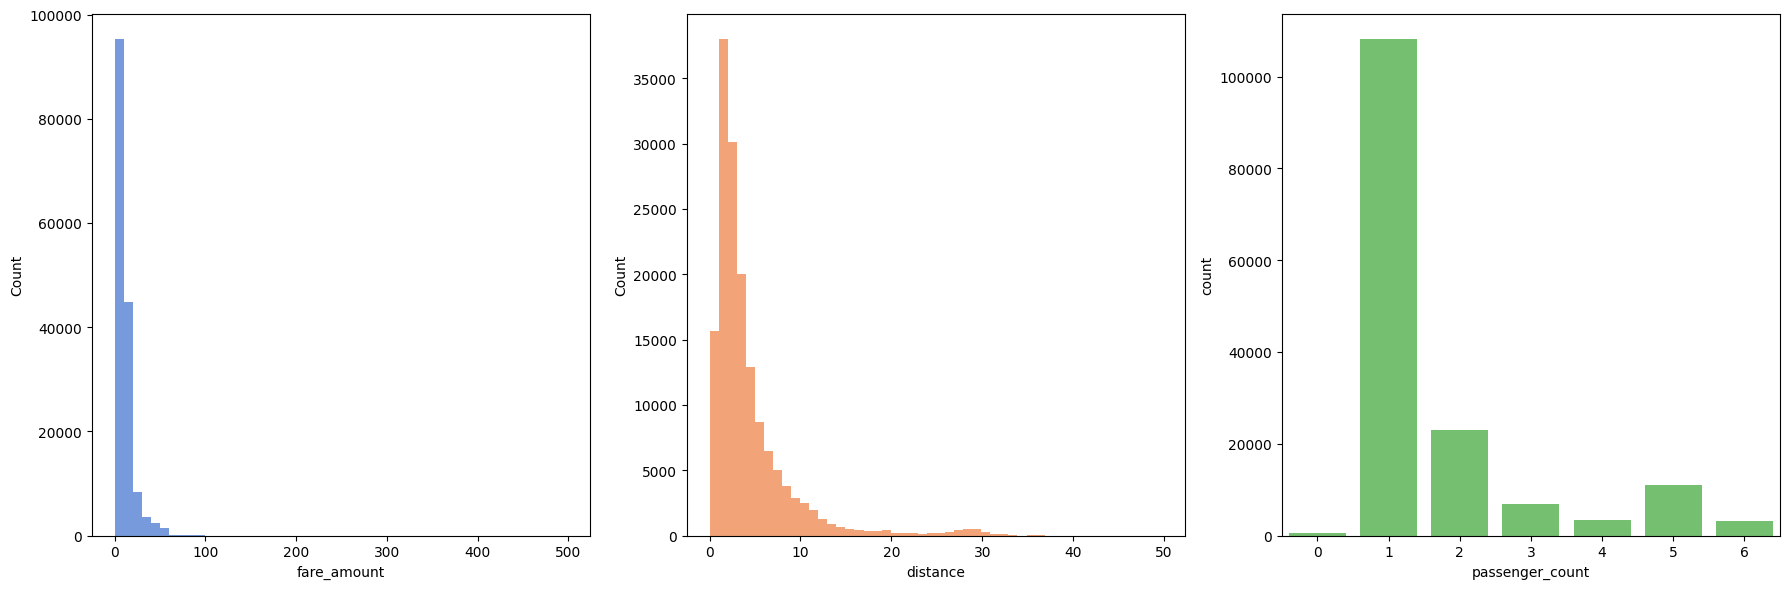

In [100]:
# Distribución de variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=train, x='fare_amount', bins=50, color=sns.color_palette("muted")[0], ax=axes[0], edgecolor='none')
sns.histplot(data=train, x='distance', bins=50, color=sns.color_palette("muted")[1], ax=axes[1], edgecolor='none')
sns.countplot(data=train, x='passenger_count', color=sns.color_palette("muted")[2], ax=axes[2])

plt.tight_layout()
plt.show()

Se observa que tanto 'fare_amount' como 'distance' están sesgadas hacía la derecha.

### Tratado de Outliers

#### *fare_amount*

In [101]:
train['fare_amount'].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

count    156420.000000
mean         11.284068
std           9.503064
min           0.010000
0.1%          2.500000
1%            3.300000
5%            4.100000
25%           6.000000
50%           8.500000
75%          12.500000
95%          30.000000
99%          52.000000
99.9%        75.000000
max         499.000000
Name: fare_amount, dtype: float64

<Axes: xlabel='fare_amount', ylabel='Count'>

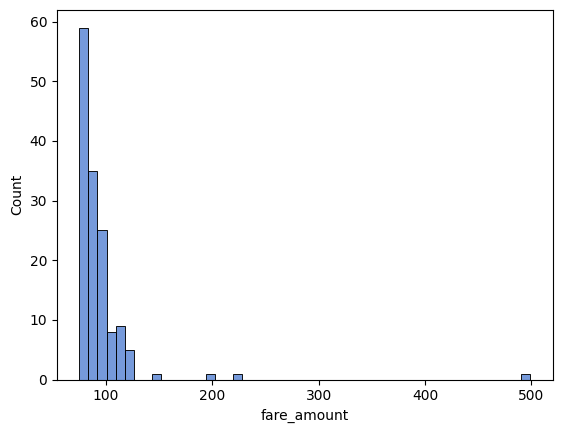

In [102]:
# Análisis de tarifas mayores al 99.9% de los datos.
sns.histplot(data=train[train['fare_amount'] > 75], x='fare_amount', bins=50, color=sns.color_palette("muted")[0])

Se obversan 4 valores atípicos de tarifa que se separan mucho del resto de los datos y también entre si. Los reemplazamos por valores nulos para su posterior imputación.

In [103]:
train['fare_amount'] = np.where(train['fare_amount'] > 150, np.nan, train['fare_amount'])
test['fare_amount'] = np.where(test['fare_amount'] > 150, np.nan, test['fare_amount'])

In [104]:
# Análisis de las tarifas hasta el percentil 1%
train[train['fare_amount'] <= 3.3]['fare_amount'].value_counts()

fare_amount
3.30    1089
2.50     573
2.90     366
3.00     284
0.01       2
0.11       1
Name: count, dtype: int64

Se observan 2 valores de tarifa muy inferiores en valor y frecuencia a los demás datos. Las reemplazamos por nulos para para su posterior imputación

In [105]:
train['fare_amount'] = np.where(train['fare_amount'] < 1, np.nan, train['fare_amount'])
test['fare_amount'] = np.where(test['fare_amount'] < 1, np.nan, test['fare_amount'])

#### *distance*

In [106]:
train['distance'].describe()

count    156420.000000
mean          4.262475
std           4.698390
min           0.000000
25%           1.602829
50%           2.770420
75%           5.036725
max          49.804722
Name: distance, dtype: float64

La distancia del viaje no puede ser 0, porque no habría viaje. Asumimos que corresponden a viajes que comienzan y terminan en la misma ubicación pero tienen un recorrido con paradas intermedias, como no tenemos información sobre paradas intermedias, reemplazamos los valores 0 de distancia por nulos para su posterior imputacíon.

In [107]:
train = train.assign(distance=lambda x: x['distance'].replace(0, np.nan))
test = test.assign(distance=lambda x: x['distance'].replace(0, np.nan))

# Estadísticas descriptivas de distancias no nulas
train['distance'].describe(percentiles=[0.001, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 0.999])

count    154850.000000
mean          4.305691
std           4.702405
min           0.000084
0.1%          0.001935
1%            0.283168
5%            0.777522
25%           1.631325
50%           2.798514
75%           5.078414
95%          12.365005
99%          28.009501
99.9%        31.981878
max          49.804722
Name: distance, dtype: float64

No vamos a considerar como válida ninguna distancia menor a 0.1Km. Reemplazamos por null para posterior imputación.

In [108]:
train['distance'] = np.where(train['distance'] < 0.1, np.nan, train['distance'])
test['distance'] = np.where(test['distance'] < 0.1, np.nan, test['distance'])

In [109]:
# Descarta viajes sin tarifa y sin distancia. No imputables.
train = train[~(train['fare_amount'].isnull() & train['distance'].isnull())]

### Ingenieria de características

#### *date*

In [110]:
train['hour'] = train['date'].dt.hour
train['day'] = train['date'].dt.day_of_week
train['month'] = train['date'].dt.month
train['minute'] = train['date'].dt.minute

test['hour'] = test['date'].dt.hour
test['day'] = test['date'].dt.day_of_week
test['month'] = test['date'].dt.month
test['minute'] = test['date'].dt.minute

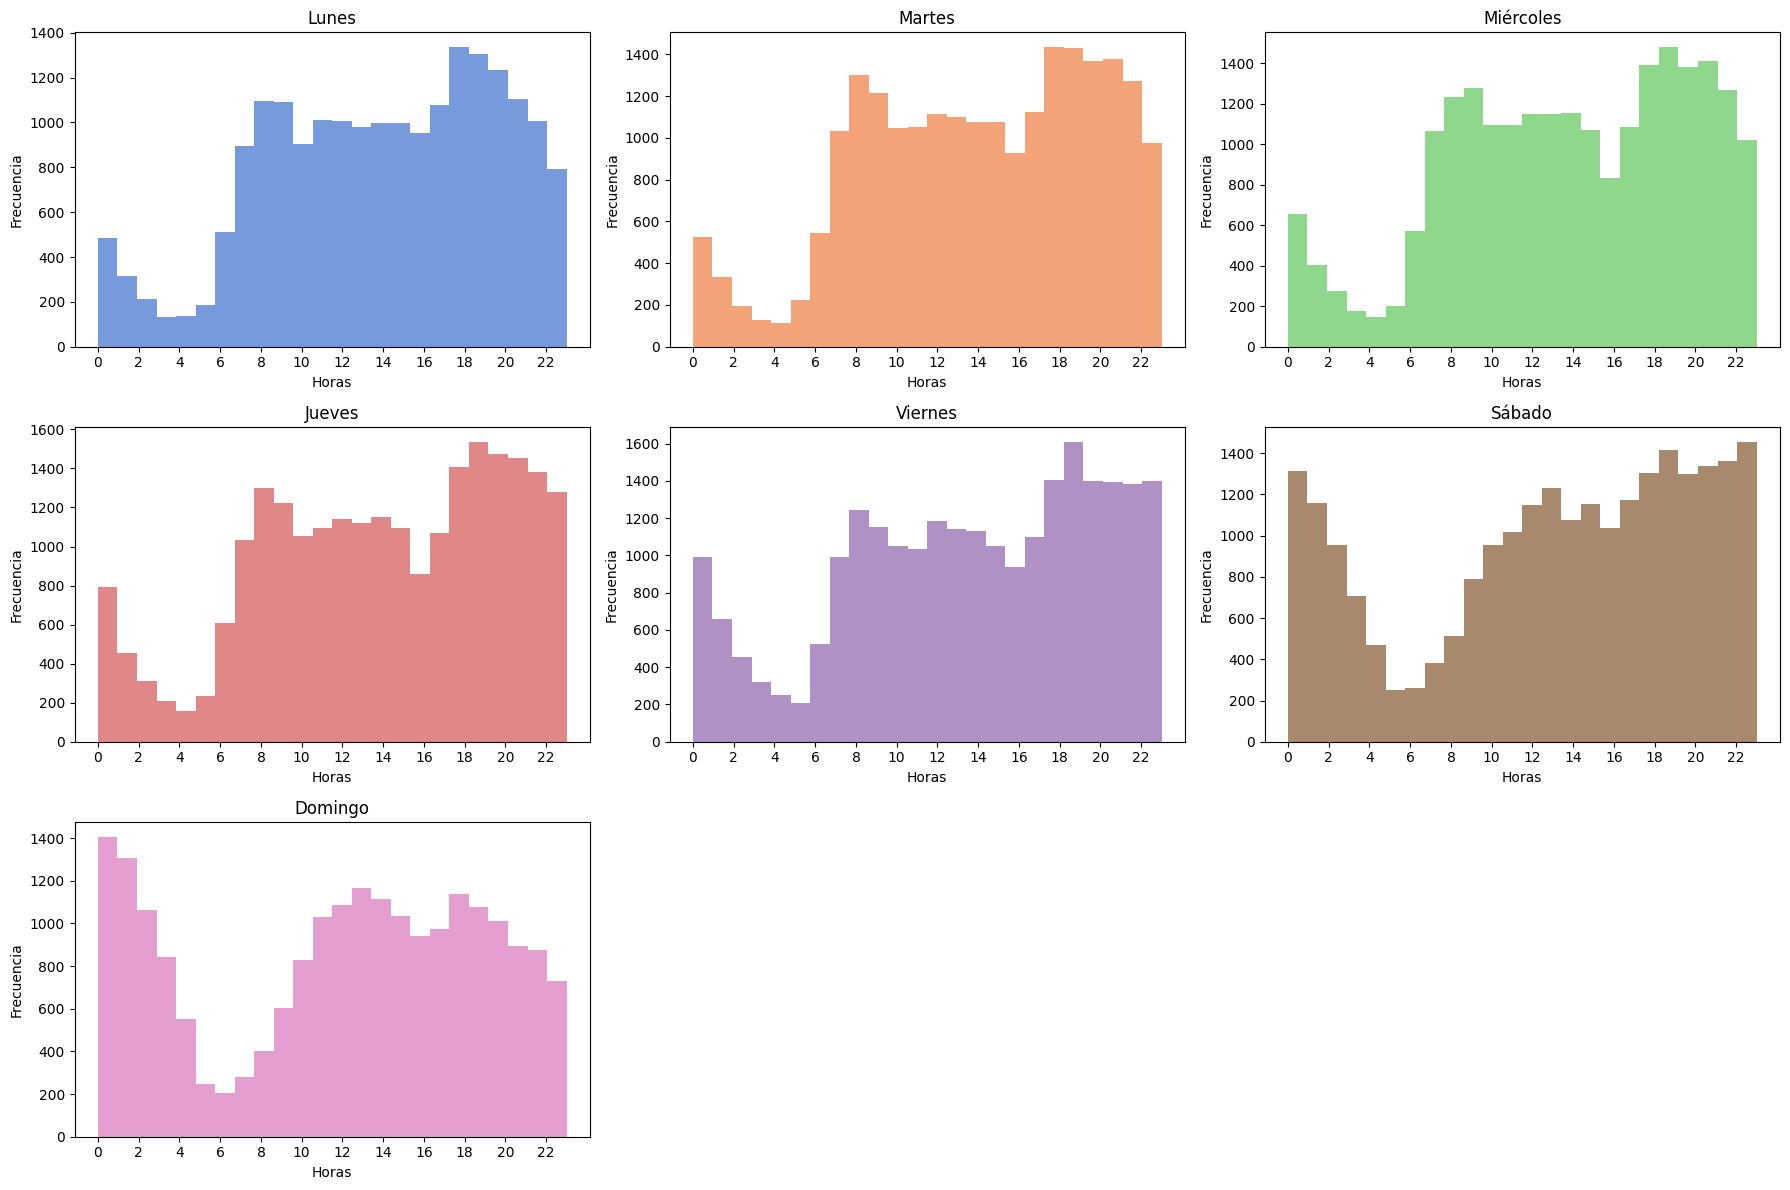

In [111]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

dias_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

for i, dia in enumerate(dias_semana):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=train[train["day"] == i],
        x="hour",
        bins=24,
        color=sns.color_palette("muted", 7)[i],
        edgecolor="none",
        ax=ax
    )
    ax.set_title(dia)
    ax.set_xlabel("Horas")
    ax.set_ylabel("Frecuencia")
    ax.set_xticks(range(0, 24, 2))

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()

Se observa que los días Lunes, Martes y Miércoles presentan una distribución muy parecida, con una rápida diminución de viajes luego de las 22 horas.
Los Jueves, Viernes y Sábados presentan una mayor cantidad de actividad en horarios nocturnos, y un aumento en la demanda luego de las 22 horas, especialmente los viernes y sábados.
Los domingos presentan un comportamiento único, teníendo su momento de mayor actividad a la madrugada y una baja de actividad a partir de las 18.

In [112]:
# Genera variables dummys de grupos de dias de la semana con distribuciones similares
train['is_mon_tue_wed'] = np.where(train['day'].isin([0, 1, 2]), 1, 0)
train['is_thu_fri_sat'] = np.where(train['day'].isin([3, 4, 5]), 1, 0)
train['is_sun'] = np.where(train['day'] == 6, 1, 0)

test['is_mon_tue_wed'] = np.where(test['day'].isin([0, 1, 2]), 1, 0)
test['is_thu_fri_sat'] = np.where(test['day'].isin([3, 4, 5]), 1, 0)
test['is_sun'] = np.where(test['day'] == 6, 1, 0)

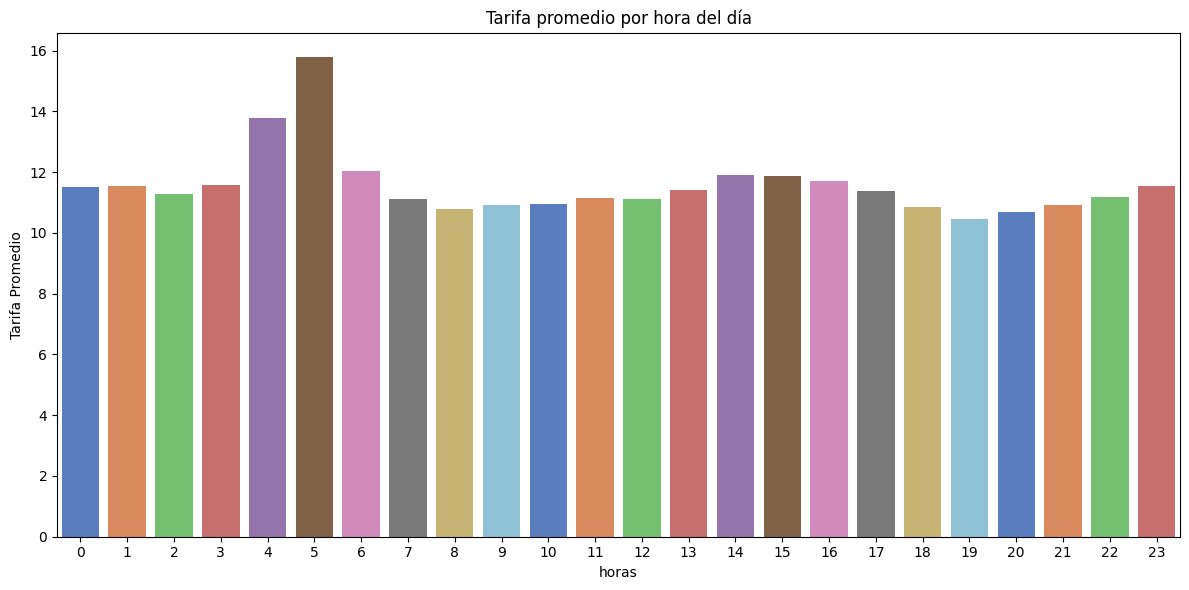

In [113]:
tarifa_promedio_por_hora = train.groupby("hour")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=tarifa_promedio_por_hora,
    x="hour",
    y="promedio",
    hue="hour",
    palette="muted",
    legend=False
)

plt.title("Tarifa promedio por hora del día")
plt.xlabel("horas")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

Las tárifas promedio mas altas se dan a las 4 y 5 de la madrugada de forma acentuada por sobre el resto de las horas del día.

In [114]:
# Genera variable dummy para indicar horario de madrugada
train['is_early_morning'] = np.where(train['hour'].isin([4, 5]), 1, 0)

test['is_early_morning'] = np.where(test['hour'].isin([4, 5]), 1, 0)

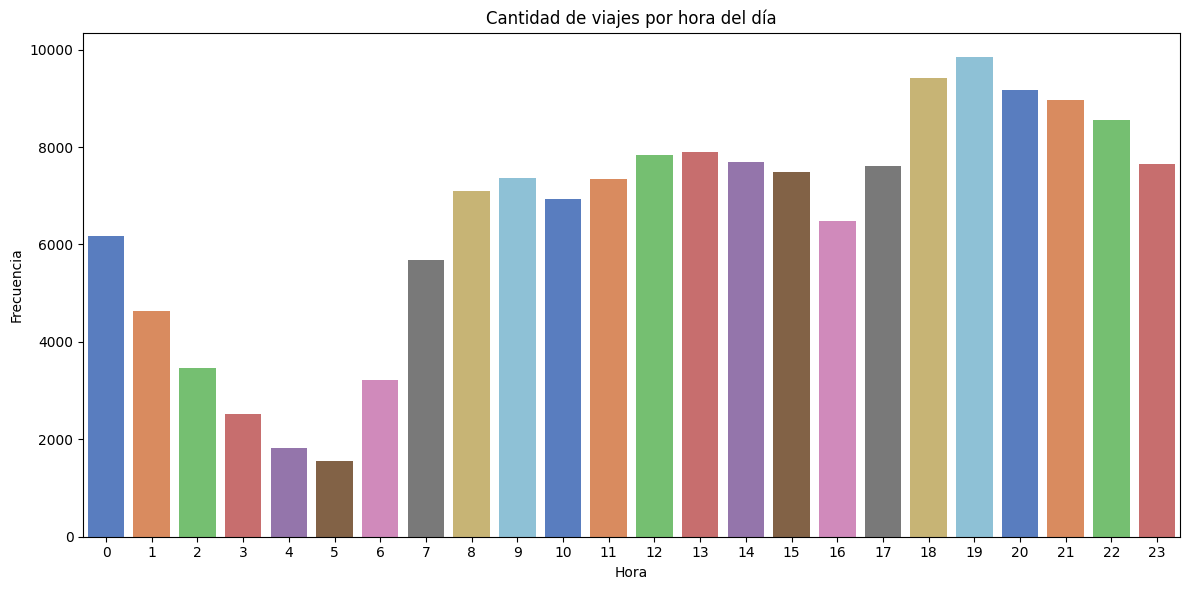

In [115]:
viajes_por_hora = train.groupby("hour")['fare_amount'].size().reset_index(name="frecuencia")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=viajes_por_hora,
    x="hour",
    y="frecuencia",
    hue="hour",
    palette="muted",
    legend=False
)

plt.title("Cantidad de viajes por hora del día")
plt.xlabel("Hora")
plt.ylabel("Frecuencia")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [116]:
train['hour'].value_counts().head(10)

hour
19    9853
18    9409
20    9172
21    8975
22    8549
13    7894
12    7834
14    7692
23    7657
17    7604
Name: count, dtype: int64

El horario de mayor actividad general se da marcadamente entre las 18 y las 22.

In [117]:
# Genera variable dummy de alta actividad
train['is_high_activity'] = np.where(train['hour'].isin([18, 19, 20, 21, 22]), 1, 0)

test['is_high_activity'] = np.where(test['hour'].isin([18, 19, 20, 21, 22]), 1, 0)

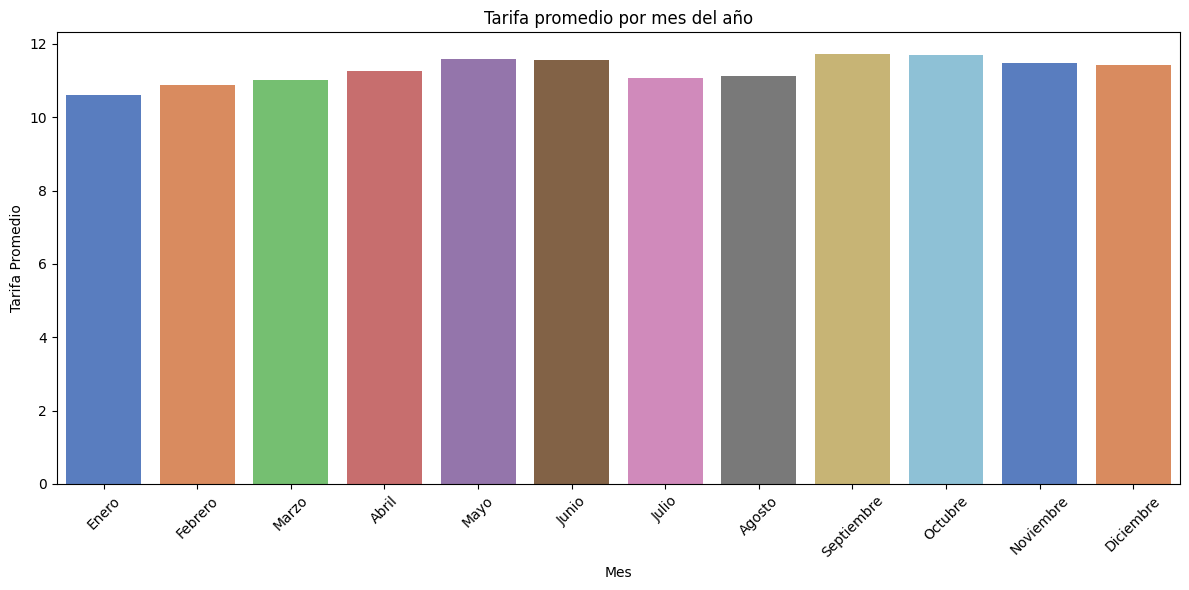

In [118]:
tarifa_promedio_por_mes = train.groupby("month")['fare_amount'].mean().reset_index(name="promedio")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=tarifa_promedio_por_mes,
    x="month",
    y="promedio",
    hue="month",
    palette="muted",
    legend=False,
)

plt.xticks(
    ticks=range(12),
    labels=["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"],
    rotation=45
)

plt.title("Tarifa promedio por mes del año")
plt.xlabel("Mes")
plt.ylabel("Tarifa Promedio")

plt.tight_layout()
plt.show()

La tarifa promedio a lo largo de los meses no muestra ninguna tendencia o particularidad clara por lo que decidimos no incluir ninguna variable relacionada para reducir el riesgo de overfitting.

In [119]:
# Crea variable dummy para identificar viajes en días feriados
us_holidays = holidays.US(years=train["date"].dt.year.unique(), state="NY")
train["is_holiday"] = train["date"].dt.date.isin(us_holidays)

In [120]:
train.groupby("is_holiday")['fare_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
is_holiday,,,,,,,,
False,151602.0,11.274689,9.376249,2.5,6.0,8.5,12.5,121.33
True,4811.0,11.373635,9.791142,2.5,6.0,8.5,12.5,104.00


El hecho de que el sea o no feriado no parece afectar en nada a la tarifa. por lo que decidimos eliminarla para reducir el riesgo de overfitting.

In [121]:
train.drop(columns=[ 'is_holiday'], inplace=True)

In [122]:
train.drop(columns=[ 'day', 'hour', 'month', 'minute'], inplace=True)

test.drop(columns=[ 'day', 'hour', 'month', 'minute'], inplace=True)

# Regresión Lineal

## preprocesamiento

In [123]:
# quito nans de todos los conjuntos de datos (esto en realidad habría que imputarlo)
train = train.dropna()
test = test.dropna()

In [124]:
# dropeo de coordenadas, date y passenger_count
train = train.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'date', 'passenger_count', 'is_sun'])
test = test.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'date', 'passenger_count', 'is_sun'])

In [125]:
X_train = train.drop(columns=['fare_amount'],axis=1)
y_train = train['fare_amount']
X_test = test.drop(columns=['fare_amount'],axis=1)
y_test = test['fare_amount']

# modelos de regresión

In [128]:
# Definir diferentes conjuntos de variables para probar
feature_sets = {
    'Solo_Distance': ['distance'],
    
    'Modelo_Temporal': ['distance', 'is_early_morning', 
                       'is_high_activity'],

    'Modelo_Día_Semana': ['distance', 'is_mon_tue_wed',
                          'is_thu_fri_sat'],
    
    'Modelo_Completo': ['distance', 'is_mon_tue_wed',
                                  'is_thu_fri_sat', 'is_early_morning', 
                                  'is_high_activity'],
}

In [129]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
results = []

print("COMPARACIÓN DE DIFERENTES CONJUNTOS DE VARIABLES")

for model_name, features in feature_sets.items():
    # Preparar datos
    X_train = train[features]
    y_train = train['fare_amount']
    X_test = test[features]
    y_test = test['fare_amount']
    
    # Entrenar modelo
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    # Calcular métricas
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Guardar resultados
    results.append({
        'Modelo': model_name,
        'Variables': len(features),
        'R2_Train': train_r2,
        'R2_Test': test_r2,
        'RMSE_Test': test_rmse,
        'MAE_Test': test_mae,
        'Diferencia_R2': abs(train_r2 - test_r2)  # Para detectar overfitting
    })
    
    print(f"\n{model_name}:")
    print(f"  Variables: {features}")
    print(f"  R² Train: {train_r2:.4f}")
    print(f"  R² Test:  {test_r2:.4f}")
    print(f"  RMSE:     {test_rmse:.4f}")
    print(f"  MAE:      {test_mae:.4f}")

COMPARACIÓN DE DIFERENTES CONJUNTOS DE VARIABLES

Solo_Distance:
  Variables: ['distance']
  R² Train: 0.7847
  R² Test:  0.7856
  RMSE:     4.3851
  MAE:      2.4438

Modelo_Temporal:
  Variables: ['distance', 'is_early_morning', 'is_high_activity']
  R² Train: 0.7852
  R² Test:  0.7861
  RMSE:     4.3808
  MAE:      2.4412

Modelo_Día_Semana:
  Variables: ['distance', 'is_mon_tue_wed', 'is_thu_fri_sat']
  R² Train: 0.7849
  R² Test:  0.7859
  RMSE:     4.3826
  MAE:      2.4409

Modelo_Completo:
  Variables: ['distance', 'is_mon_tue_wed', 'is_thu_fri_sat', 'is_early_morning', 'is_high_activity']
  R² Train: 0.7854
  R² Test:  0.7863
  RMSE:     4.3782
  MAE:      2.4382


In [131]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R2_Test', ascending=False)

print("\n" + "="*80)
print("RESUMEN COMPARATIVO (ordenado por R² en test)")
print("="*80)
print(results_df.round(4))


RESUMEN COMPARATIVO (ordenado por R² en test)
              Modelo  Variables  R2_Train  R2_Test  RMSE_Test  MAE_Test  \
3    Modelo_Completo          5    0.7854   0.7863     4.3782    2.4382   
1    Modelo_Temporal          3    0.7852   0.7861     4.3808    2.4412   
2  Modelo_Día_Semana          3    0.7849   0.7859     4.3826    2.4409   
0      Solo_Distance          1    0.7847   0.7856     4.3851    2.4438   

   Diferencia_R2  
3         0.0009  
1         0.0009  
2         0.0010  
0         0.0009  


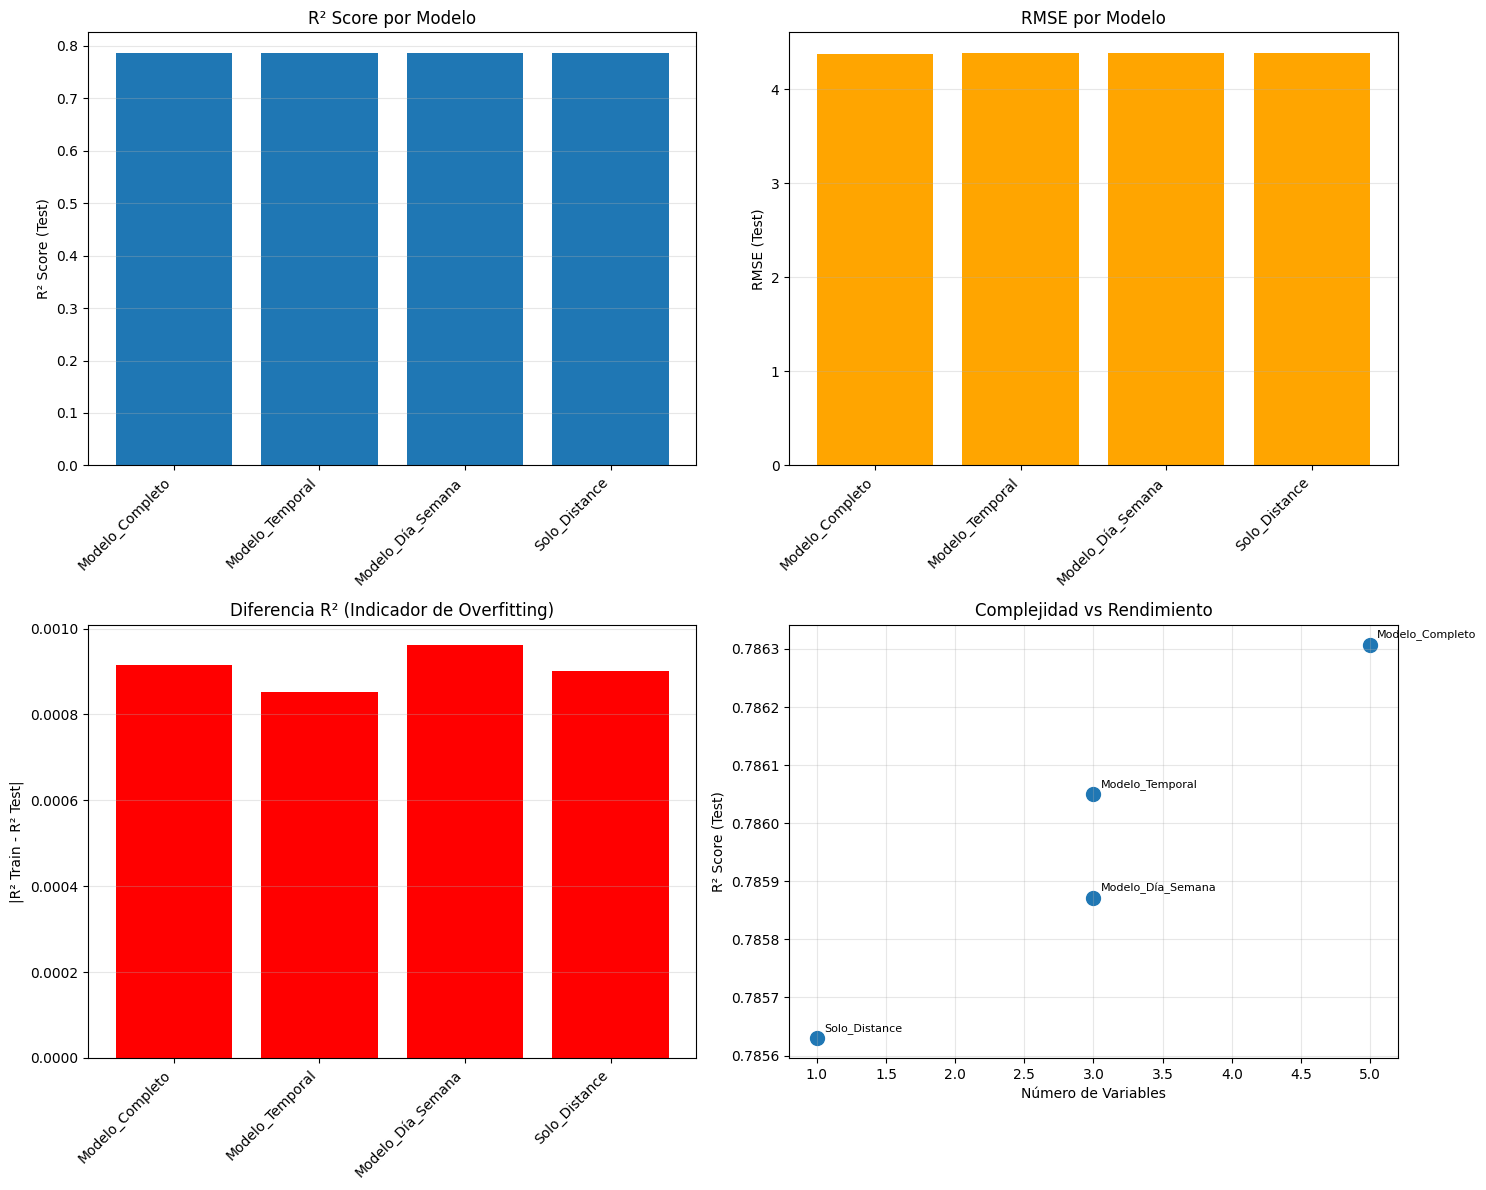

In [132]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Score comparison
axes[0, 0].bar(range(len(results_df)), results_df['R2_Test'])
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[0, 0].set_ylabel('R² Score (Test)')
axes[0, 0].set_title('R² Score por Modelo')
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[0, 1].bar(range(len(results_df)), results_df['RMSE_Test'], color='orange')
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[0, 1].set_ylabel('RMSE (Test)')
axes[0, 1].set_title('RMSE por Modelo')
axes[0, 1].grid(axis='y', alpha=0.3)

# Overfitting detection (diferencia entre train y test R²)
axes[1, 0].bar(range(len(results_df)), results_df['Diferencia_R2'], color='red')
axes[1, 0].set_xticks(range(len(results_df)))
axes[1, 0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[1, 0].set_ylabel('|R² Train - R² Test|')
axes[1, 0].set_title('Diferencia R² (Indicador de Overfitting)')
axes[1, 0].grid(axis='y', alpha=0.3)

# Número de variables vs R²
axes[1, 1].scatter(results_df['Variables'], results_df['R2_Test'], s=100)
for i, txt in enumerate(results_df['Modelo']):
    axes[1, 1].annotate(txt, (results_df['Variables'].iloc[i], results_df['R2_Test'].iloc[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].set_xlabel('Número de Variables')
axes[1, 1].set_ylabel('R² Score (Test)')
axes[1, 1].set_title('Complejidad vs Rendimiento')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [133]:
best_model = results_df.iloc[0]

print(f"Mejor modelo: {best_model['Modelo']}")
print(f"Variables recomendadas: {feature_sets[best_model['Modelo']]}")
print(f"R² en test: {best_model['R2_Test']:.4f}")
print(f"RMSE: {best_model['RMSE_Test']:.4f}")
print(f"MAE: ${best_model['MAE_Test']:.2f}")

Mejor modelo: Modelo_Completo
Variables recomendadas: ['distance', 'is_mon_tue_wed', 'is_thu_fri_sat', 'is_early_morning', 'is_high_activity']
R² en test: 0.7863
RMSE: 4.3782
MAE: $2.44


In [134]:

# Entrenar el mejor modelo
best_features = feature_sets[best_model['Modelo']]
X_train_best = train[best_features]
y_train_best = train['fare_amount']
X_test_best = test[best_features]
y_test_best = test['fare_amount']

lr_best = LinearRegression()
lr_best.fit(X_train_best, y_train_best)

# Mostrar coeficientes
coef_df = pd.DataFrame({
    'Variable': best_features,
    'Coeficiente': lr_best.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print("Coeficientes del mejor modelo:")
print(coef_df)
print(f"Intercepto: {lr_best.intercept_:.4f}")

# Interpretación de coeficientes
print("\nInterpretación:")
for _, row in coef_df.iterrows():
    var_name = row['Variable']
    coef_value = row['Coeficiente']
    if var_name == 'distance':
        print(f"- Por cada kilómetro adicional, el precio aumenta ${coef_value:.2f}")
    elif 'is_' in var_name:
        print(f"- Cuando {var_name} es True, el precio cambia ${coef_value:.2f}")
    else:
        print(f"- {var_name}: {coef_value:.4f}")

Coeficientes del mejor modelo:
           Variable  Coeficiente
0          distance     1.746508
3  is_early_morning    -0.712472
4  is_high_activity    -0.406558
2    is_thu_fri_sat     0.386438
1    is_mon_tue_wed     0.371936
Intercepto: 3.5150

Interpretación:
- Por cada kilómetro adicional, el precio aumenta $1.75
- Cuando is_early_morning es True, el precio cambia $-0.71
- Cuando is_high_activity es True, el precio cambia $-0.41
- Cuando is_thu_fri_sat es True, el precio cambia $0.39
- Cuando is_mon_tue_wed es True, el precio cambia $0.37


# Descenso por el gradiente

In [135]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [136]:
#X_train = X_train.to_numpy()  # (154010, 6)
y_train = y_train.to_numpy().reshape(-1, 1)  # (154010, 1)
#X_test = X_test.to_numpy()  # (38519, 6)
y_test = y_test.to_numpy().reshape(-1, 1)  # (38519, 1)

In [137]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(154010, 5) (154010, 1) (38519, 5) (38519, 1)


In [138]:
# Divide el 20% para validación (ajusta test_size si quieres)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [139]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [140]:
def stochastic_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar bias
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))

    # Inicializar pesos
    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    val_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        # Acumular MSE de train durante la época (opcional, pero para monitoreo)
        epoch_train_mse = 0
        for j in range(n):
            # Muestra como 2D para matmul
            x_sample = X_train[j:j+1]
            y_sample = y_train[j:j+1]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            epoch_train_mse += np.mean(error ** 2)  # Suma MSE por muestra

            # Gradiente (para batch=1)
            gradient = -2 * np.matmul(x_sample.T, error) / 1

            W = W - (lr * gradient)

        # MSE promedio de train por época
        train_errors.append(epoch_train_mse / n)

        # MSE en val (solo una vez por época)
        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

    # Graficar (ahora con solo 'epochs' puntos)
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs épocas (SGD)')
    plt.show()

    return W

In [141]:
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, batch_size=32):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar bias
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))

    # Inicializar pesos
    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    val_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        # Acumular MSE de train durante la época
        epoch_train_mse = 0
        total_samples = 0
        for j in range(0, n, batch_size):
            x_batch = X_train[j:j+batch_size]
            y_batch = y_train[j:j+batch_size]

            current_batch_size = x_batch.shape[0]
            if current_batch_size == 0:
                continue

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            batch_mse = np.mean(error ** 2)
            epoch_train_mse += batch_mse * current_batch_size
            total_samples += current_batch_size

            # Gradiente
            gradient = -2 * np.matmul(x_batch.T, error) / current_batch_size

            W = W - (lr * gradient)

        # MSE promedio de train por época
        train_errors.append(epoch_train_mse / total_samples if total_samples > 0 else 0)

        # MSE en val (solo una vez por época)
        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs épocas (Mini-Batch GD)')
    plt.show()

    return W

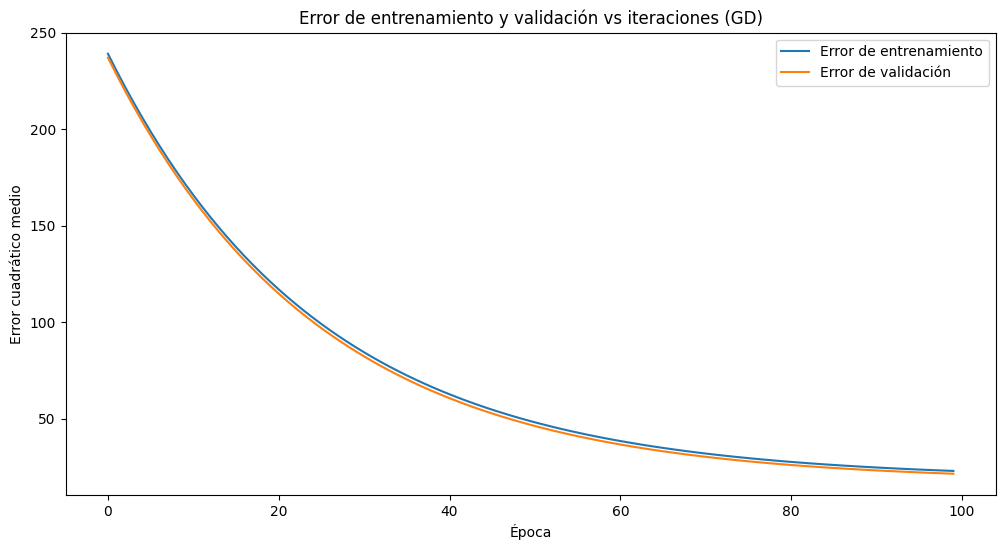

In [142]:
gd = gradient_descent(X_train_new, y_train_new, X_val, y_val, lr=0.01, epochs=100)

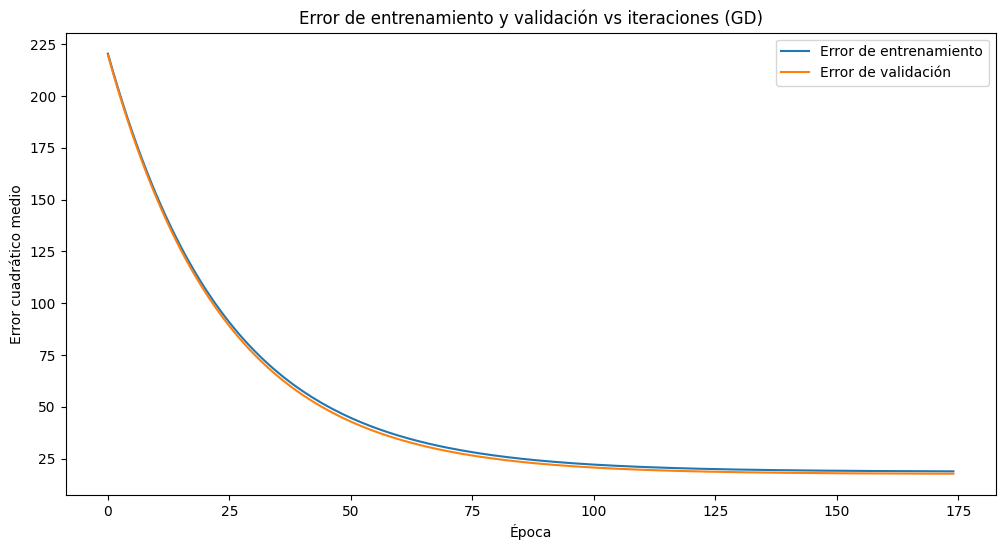

In [143]:
gd = gradient_descent(X_train_new, y_train_new, X_val, y_val, lr=0.01, epochs=175)

In [144]:
gd

array([[10.95513029],
       [ 7.9899272 ],
       [-0.04755642],
       [-0.05069076],
       [-0.1027498 ],
       [-0.19587191]])

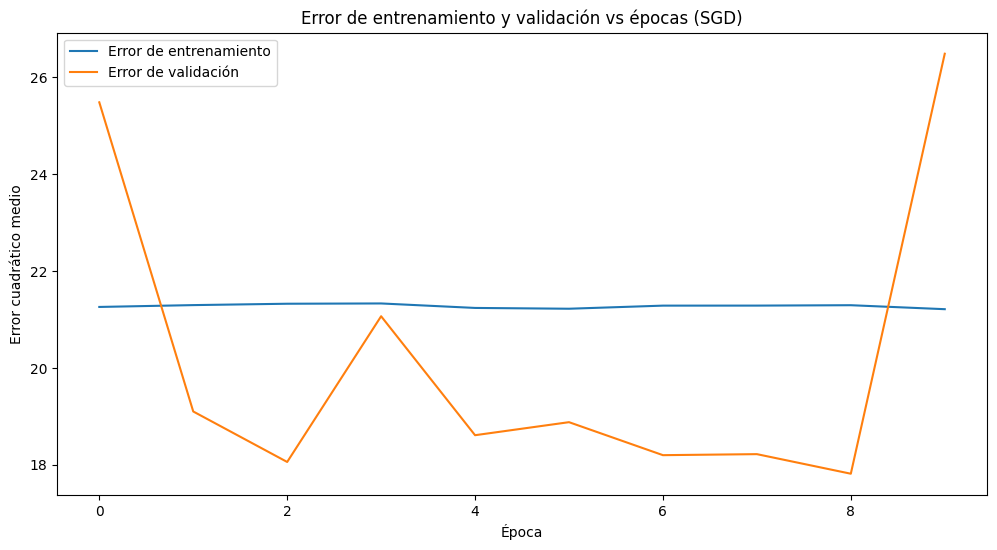

In [145]:
sgd = stochastic_gradient_descent(X_train_new, y_train_new, X_val, y_val, lr=0.01, epochs=10)

In [146]:
sgd

array([[11.89442001],
       [ 8.88701096],
       [ 0.20855009],
       [-0.18210312],
       [ 2.65717671],
       [ 0.05861174]])

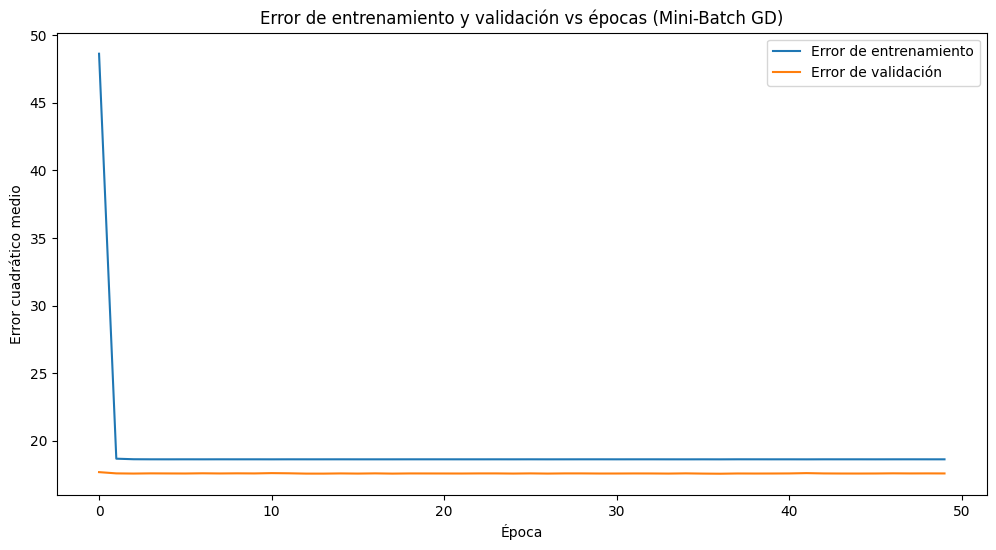

In [147]:
mb_gd = mini_batch_gradient_descent(X_train_new, y_train_new, X_val, y_val, lr=0.001, epochs=50, batch_size=64)

In [148]:
mb_gd

array([[11.28207126],
       [ 8.23780935],
       [ 0.21581499],
       [ 0.18509919],
       [-0.1233299 ],
       [-0.16655827]])

In [149]:
# Agrega la columna de bias (unos) a X_test: 
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

MSE de descenso por el gradiente (no estocástico ni mini-batch). Completar.

In [150]:
# Predice
y_pred = np.matmul(X_test, gd)

In [151]:
# MSE
mse_test = np.mean((y_test - y_pred) ** 2)

In [152]:
mse_test

np.float64(19.409390841795773)

# Regularización

In [154]:
# Definir columnas a usar (excluyendo 'fare_amount')
feature_columns = ['distance', 'is_mon_tue_wed', 'is_thu_fri_sat', 'is_early_morning', 'is_high_activity']
X_train = train[feature_columns].to_numpy()
X_test = test[feature_columns].to_numpy()
y_train = train['fare_amount'].to_numpy()
y_test = test['fare_amount'].to_numpy()

In [155]:
print(f"Número de características en X_train: {X_train.shape[1]}")
print(f"Número de características en X_test: {X_test.shape[1]}")

Número de características en X_train: 5
Número de características en X_test: 5


## Ridge

In [156]:
print("Columnas en train:", train.columns.tolist())
print("Columnas en test:", test.columns.tolist())

Columnas en train: ['fare_amount', 'distance', 'is_mon_tue_wed', 'is_thu_fri_sat', 'is_early_morning', 'is_high_activity']
Columnas en test: ['fare_amount', 'distance', 'is_mon_tue_wed', 'is_thu_fri_sat', 'is_early_morning', 'is_high_activity']


In [157]:
# Asegurar que las dimensiones coincidan
if X_train.shape[1] != X_test.shape[1]:
    raise ValueError(f"X_train tiene {X_train.shape[1]} características, pero X_test tiene {X_test.shape[1]}. Revisa las columnas.")

In [158]:
# Verificar dimensiones
print(f"Número de características en X_train: {X_train.shape[1]}")
print(f"Número de características en X_test: {X_test.shape[1]}")

Número de características en X_train: 5
Número de características en X_test: 5


In [159]:
cv = 5

# Creación y entrenamiento del modelo con RidgeCV
modelo = RidgeCV(
    alphas=np.logspace(-3, 6, 200),  # 200 valores de α en escala log
    fit_intercept=True,              # Ajusta intercepto
    cv=cv,                           # 5-fold CV o TimeSeriesSplit
    scoring='neg_mean_squared_error' # Usamos MSE como métrica
)

modelo.fit(X_train, y_train)  # Entrena y selecciona el mejor α

# Acceso al modelo RidgeCV interno
mod = modelo

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 76.63410868007462


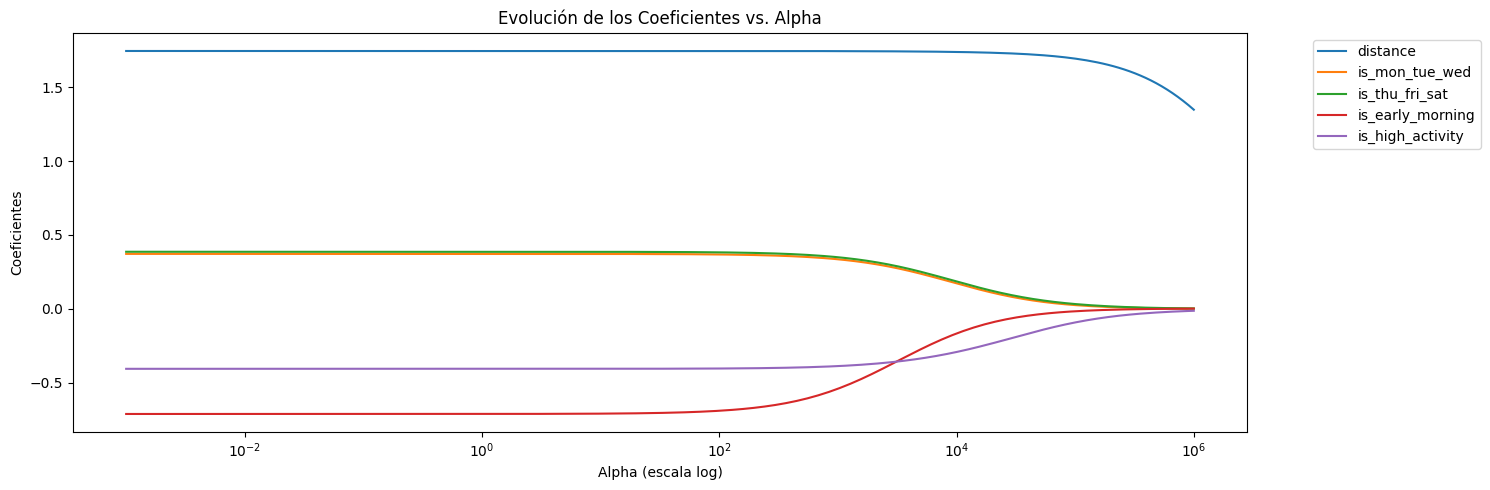

In [160]:
# Evolución de los coeficientes en función de alpha
alphas = mod.alphas
coefs = []

# Calculamos coeficientes para cada alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_.flatten())

coefs = np.array(coefs)  # Shape: (n_alphas, n_features)

# Usamos nombres de columnas reales
feature_names = feature_columns

fig, ax = plt.subplots(figsize=(15, 5))
for i in range(coefs.shape[1]):
    ax.plot(alphas, coefs[:, i], label=feature_names[i])
ax.set_xscale('log')
ax.set_xlabel('Alpha (escala log)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los Coeficientes vs. Alpha')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

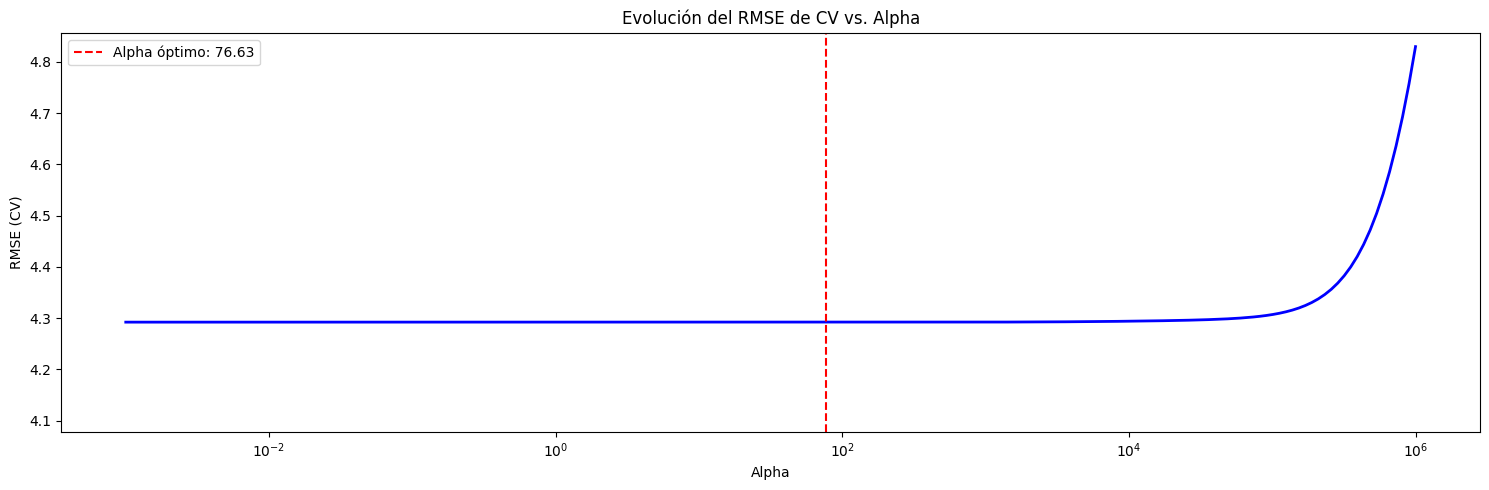

RMSE mínimo en CV: 4.2920 (en alpha=76.6341)


In [161]:
# Evolución del error de CV en función de alpha
rmse_cv = []

# Calculamos el RMSE de CV para cada alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    mse_scores = -cross_val_score(ridge, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_cv.append(np.sqrt(mse_scores.mean()))

rmse_cv = np.array(rmse_cv)
min_rmse = np.min(rmse_cv)
idx_optimo = np.argmin(rmse_cv)
alpha_optimo = alphas[idx_optimo]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, rmse_cv, 'b-', linewidth=2)
ax.axvline(alpha_optimo, color='r', linestyle='--', label=f'Alpha óptimo: {alpha_optimo:.2f}')
ax.set_xscale('log')
ax.set_ylim([min_rmse * 0.95, None])
ax.set_title('Evolución del RMSE de CV vs. Alpha')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMSE (CV)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"RMSE mínimo en CV: {min_rmse:.4f} (en alpha={alpha_optimo:.4f})")

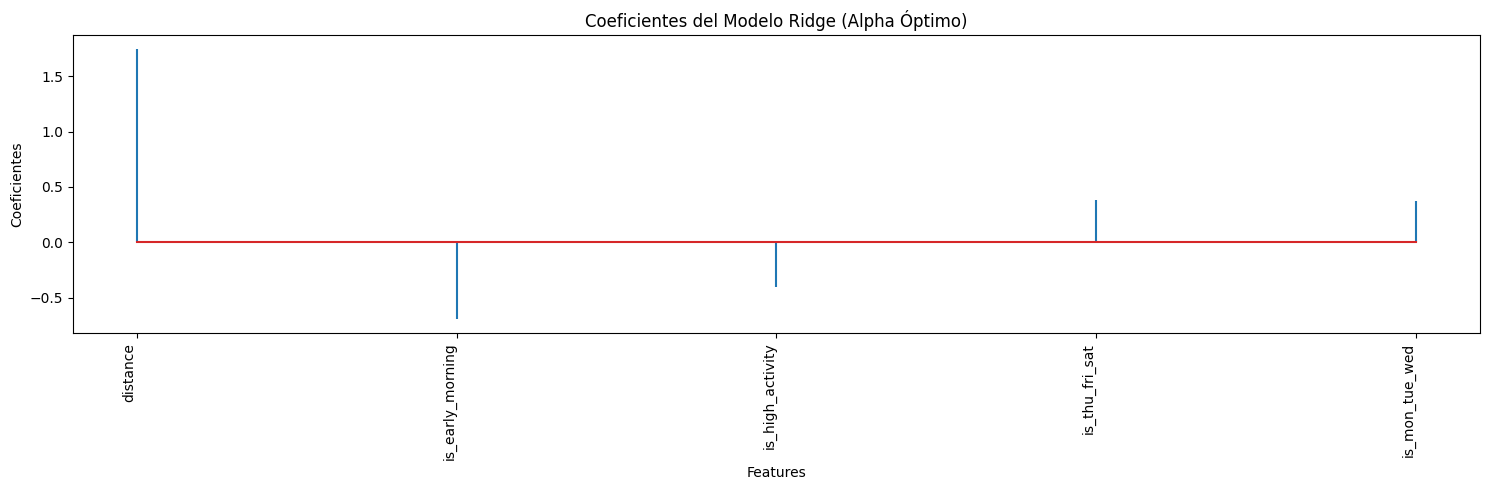

          predictor      coef
0          distance  1.746426
3  is_early_morning -0.695669
4  is_high_activity -0.404984
2    is_thu_fri_sat  0.383350
1    is_mon_tue_wed  0.368914


In [162]:
# Coeficientes del modelo final (con alpha óptimo)
df_coeficientes = pd.DataFrame({
    'predictor': feature_names,
    'coef': mod.coef_.flatten()
}).sort_values('coef', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(range(len(df_coeficientes)), df_coeficientes.coef, markerfmt=' ')
ax.set_xticks(range(len(df_coeficientes)))
ax.set_xticklabels(df_coeficientes.predictor, rotation=90, ha='right', size=10)
ax.set_xlabel('Features')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del Modelo Ridge (Alpha Óptimo)')
plt.tight_layout()
plt.show()

print(df_coeficientes)

RMSE en test: 4.3782
R² en test: 0.7863


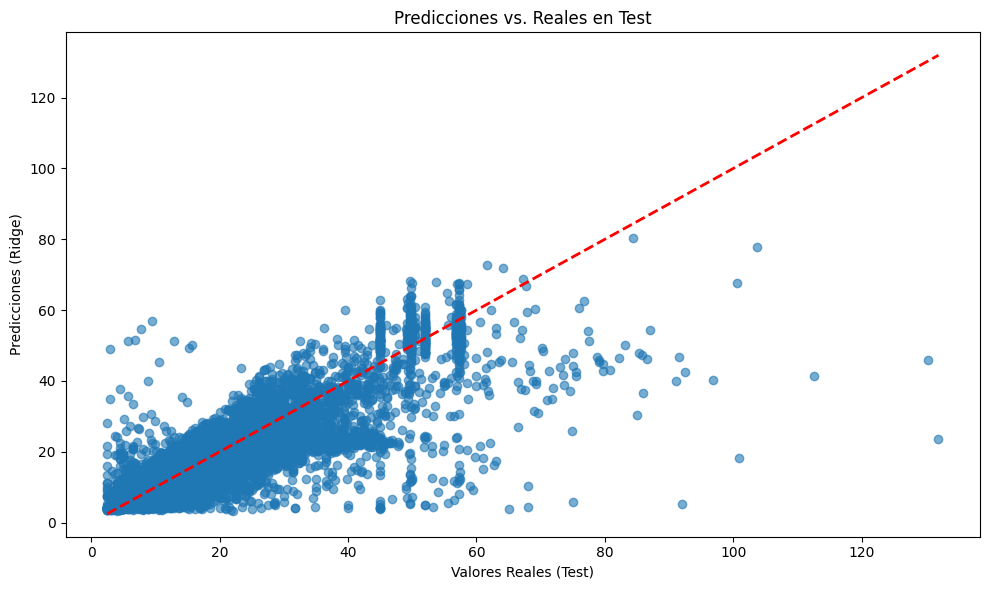

In [163]:
# Predicciones y evaluación en test
y_pred = modelo.predict(X_test)

# Calcular RMSE manualmente (sin parámetro squared)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
r2_ridge = r2_score(y_test, y_pred)

print(f"RMSE en test: {rmse_ridge:.4f}")
print(f"R² en test: {r2_ridge:.4f}")

# Gráfico de predicciones vs reales
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Valores Reales (Test)')
ax.set_ylabel('Predicciones (Ridge)')
ax.set_title('Predicciones vs. Reales en Test')
plt.tight_layout()
plt.show()

## Lasso

In [164]:
# Creación y entrenamiento del modelo con LassoCV
modelo = LassoCV(
    alphas=np.logspace(-3, 6, 200),  # Mismo rango de α que Ridge
    fit_intercept=True,
    cv=5,                            # KFold con 5 folds (no series temporales)
    max_iter=10000,                  # Más iteraciones para convergencia
    tol=1e-3                         # Tolerancia para convergencia
)

modelo.fit(X_train, y_train)

# Acceso al modelo LassoCV
mod = modelo

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 0.001


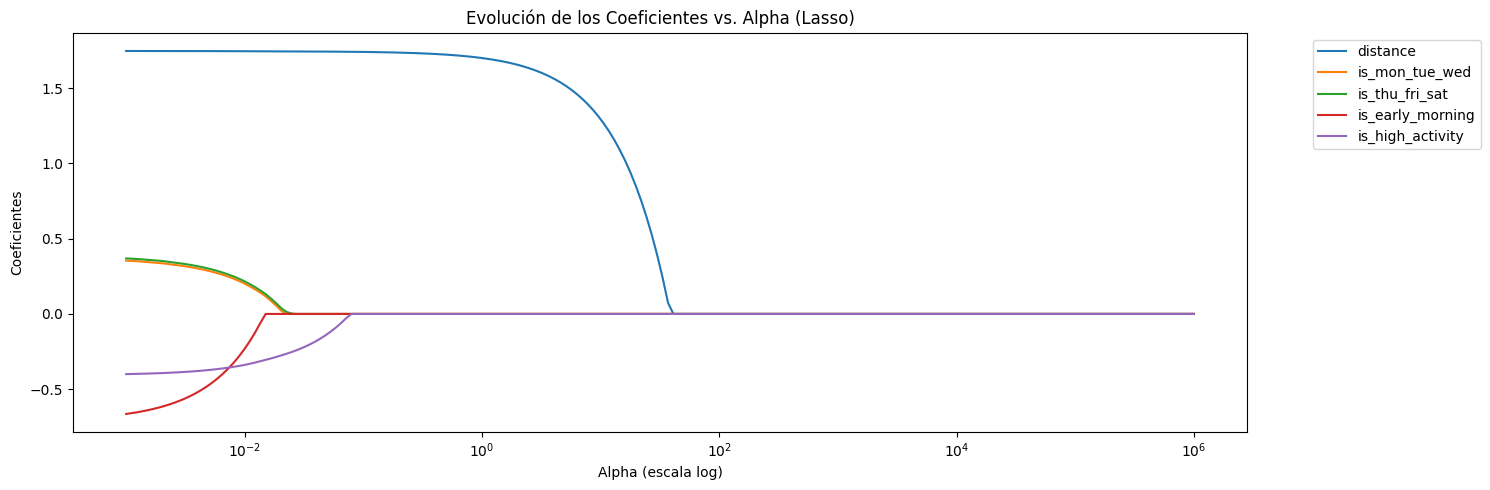

In [165]:
# Evolución de los coeficientes
coefs = []
for alpha in mod.alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000, tol=1e-3)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_.flatten())

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(15, 5))
for i in range(coefs.shape[1]):
    ax.plot(mod.alphas, coefs[:, i], label=feature_columns[i])
ax.set_xscale('log')
ax.set_xlabel('Alpha (escala log)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los Coeficientes vs. Alpha (Lasso)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

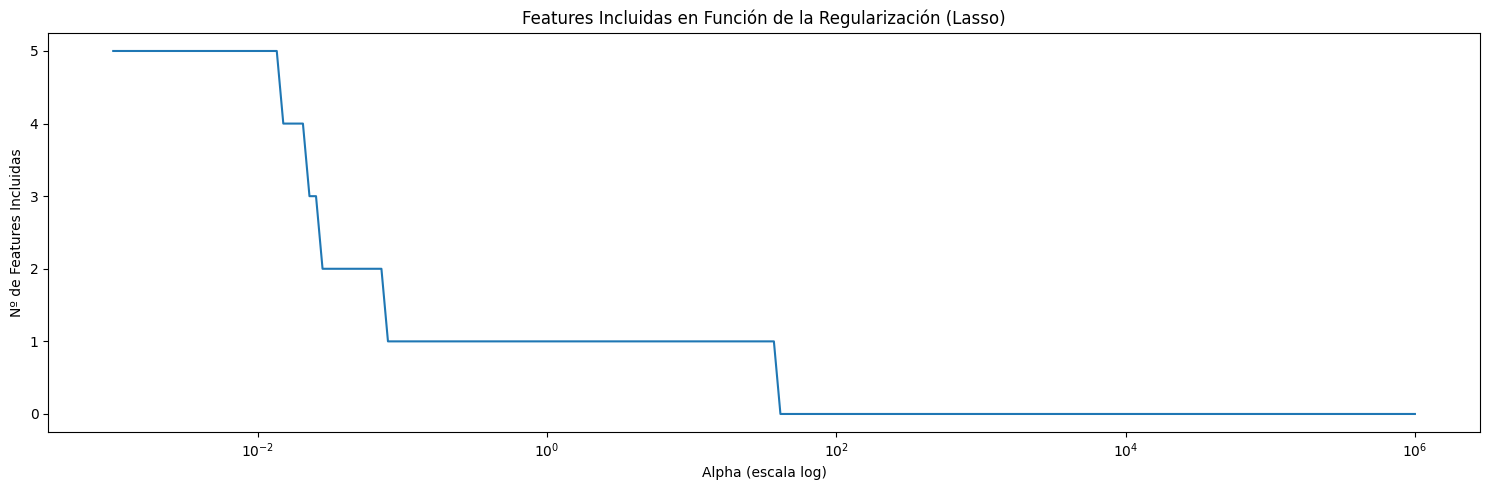

In [166]:
# Número de features incluidas (coeficientes != 0)
n_predictores = []
for alpha in mod.alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000, tol=1e-3)
    lasso.fit(X_train, y_train)
    coef_no_cero = np.sum(lasso.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mod.alphas, n_predictores)
ax.set_xscale('log')
ax.set_xlabel('Alpha (escala log)')
ax.set_ylabel('Nº de Features Incluidas')
ax.set_title('Features Incluidas en Función de la Regularización (Lasso)')
plt.tight_layout()
plt.show()

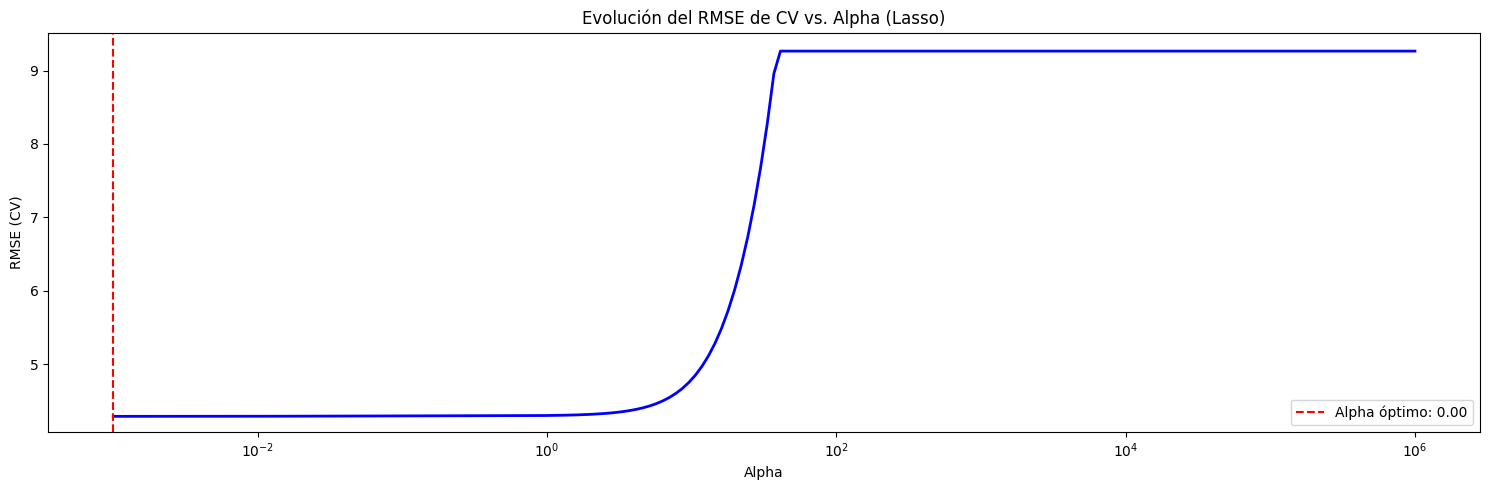

RMSE mínimo en CV: 4.2920 (en alpha=0.0010)


In [167]:
# Evolución del error de validación cruzada
rmse_cv = []
for alpha in mod.alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000, tol=1e-3)
    mse_scores = -cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv.append(np.sqrt(mse_scores.mean()))

rmse_cv = np.array(rmse_cv)
min_rmse = np.min(rmse_cv)
idx_optimo = np.argmin(rmse_cv)
alpha_optimo = mod.alphas[idx_optimo]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mod.alphas, rmse_cv, 'b-', linewidth=2)
ax.axvline(alpha_optimo, color='r', linestyle='--', label=f'Alpha óptimo: {alpha_optimo:.2f}')
ax.set_xscale('log')
ax.set_ylim([min_rmse * 0.95, None])
ax.set_title('Evolución del RMSE de CV vs. Alpha (Lasso)')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMSE (CV)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"RMSE mínimo en CV: {min_rmse:.4f} (en alpha={alpha_optimo:.4f})")

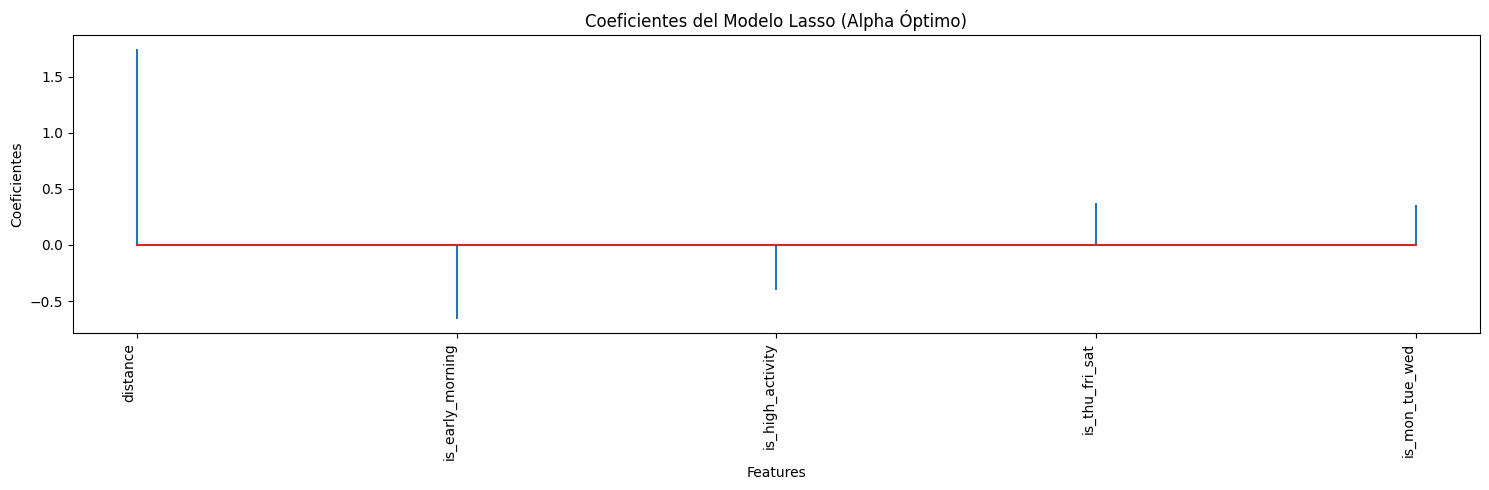

          predictor      coef
0          distance  1.746323
3  is_early_morning -0.664305
4  is_high_activity -0.399694
2    is_thu_fri_sat  0.368886
1    is_mon_tue_wed  0.354192

Features seleccionadas (coef != 0):
          predictor      coef
0          distance  1.746323
3  is_early_morning -0.664305
4  is_high_activity -0.399694
2    is_thu_fri_sat  0.368886
1    is_mon_tue_wed  0.354192


In [168]:
# Coeficientes del modelo final
df_coeficientes = pd.DataFrame({
    'predictor': feature_columns,
    'coef': mod.coef_.flatten()
}).sort_values('coef', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(range(len(df_coeficientes)), df_coeficientes.coef, markerfmt=' ')
ax.set_xticks(range(len(df_coeficientes)))
ax.set_xticklabels(df_coeficientes.predictor, rotation=90, ha='right', size=10)
ax.set_xlabel('Features')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del Modelo Lasso (Alpha Óptimo)')
plt.tight_layout()
plt.show()

print(df_coeficientes)
print("\nFeatures seleccionadas (coef != 0):")
print(df_coeficientes[df_coeficientes.coef != 0])

RMSE en test (Lasso): 4.3782
R² en test (Lasso): 0.7863


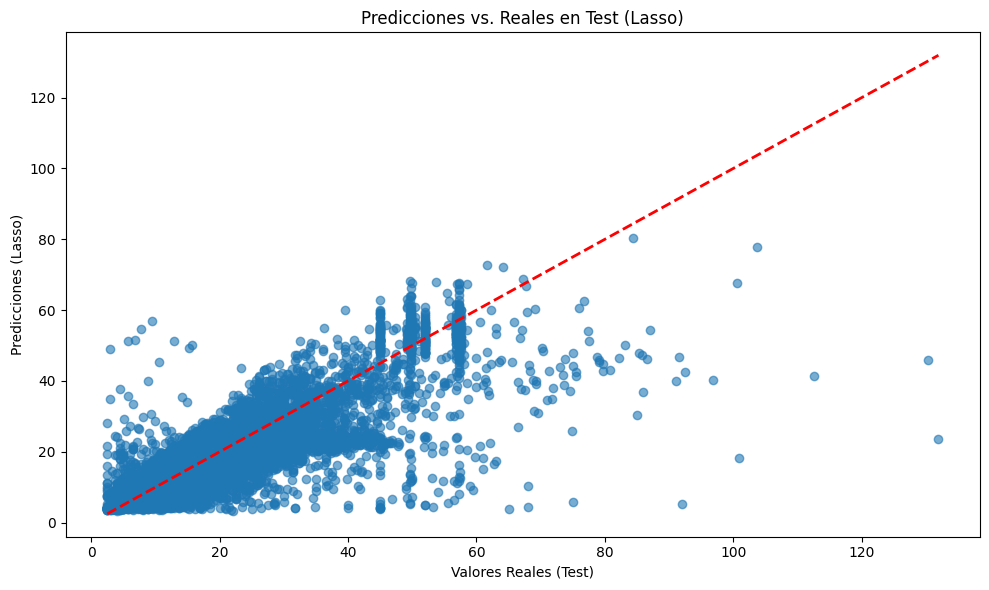

In [169]:
# Predicciones y evaluación en test
y_pred = modelo.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lasso = r2_score(y_test, y_pred)

print(f"RMSE en test (Lasso): {rmse_lasso:.4f}")
print(f"R² en test (Lasso): {r2_lasso:.4f}")

# Gráfico de predicciones vs reales
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Valores Reales (Test)')
ax.set_ylabel('Predicciones (Lasso)')
ax.set_title('Predicciones vs. Reales en Test (Lasso)')
plt.tight_layout()
plt.show()

## ElasticNET

In [170]:
# Creación y entrenamiento del modelo con ElasticNetCV
modelo = ElasticNetCV(
    alphas=np.logspace(-3, 6, 200),  # Mismo rango de α
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],  # Balance entre L1 y L2
    fit_intercept=True,
    cv=5,                            # KFold con 5 folds
    max_iter=10000,
    tol=1e-3
)

modelo.fit(X_train, y_train)

# Acceso al modelo ElasticNetCV
mod = modelo

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

Mejor valor de alpha encontrado: 0.001
Mejor valor de l1_ratio encontrado: 0.1


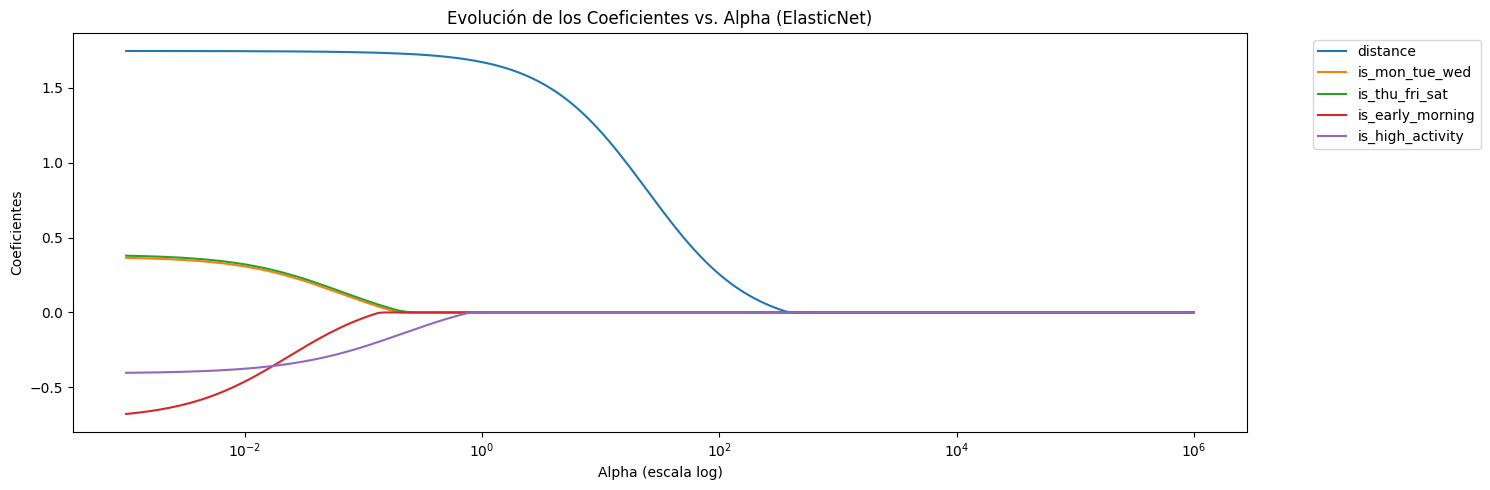

In [171]:
# Evolución de los coeficientes (usando el l1_ratio óptimo)
coefs = []
for alpha in mod.alphas:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=mod.l1_ratio_, fit_intercept=True, max_iter=10000, tol=1e-3)
    elasticnet.fit(X_train, y_train)
    coefs.append(elasticnet.coef_.flatten())

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(15, 5))
for i in range(coefs.shape[1]):
    ax.plot(mod.alphas, coefs[:, i], label=feature_columns[i])
ax.set_xscale('log')
ax.set_xlabel('Alpha (escala log)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los Coeficientes vs. Alpha (ElasticNet)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

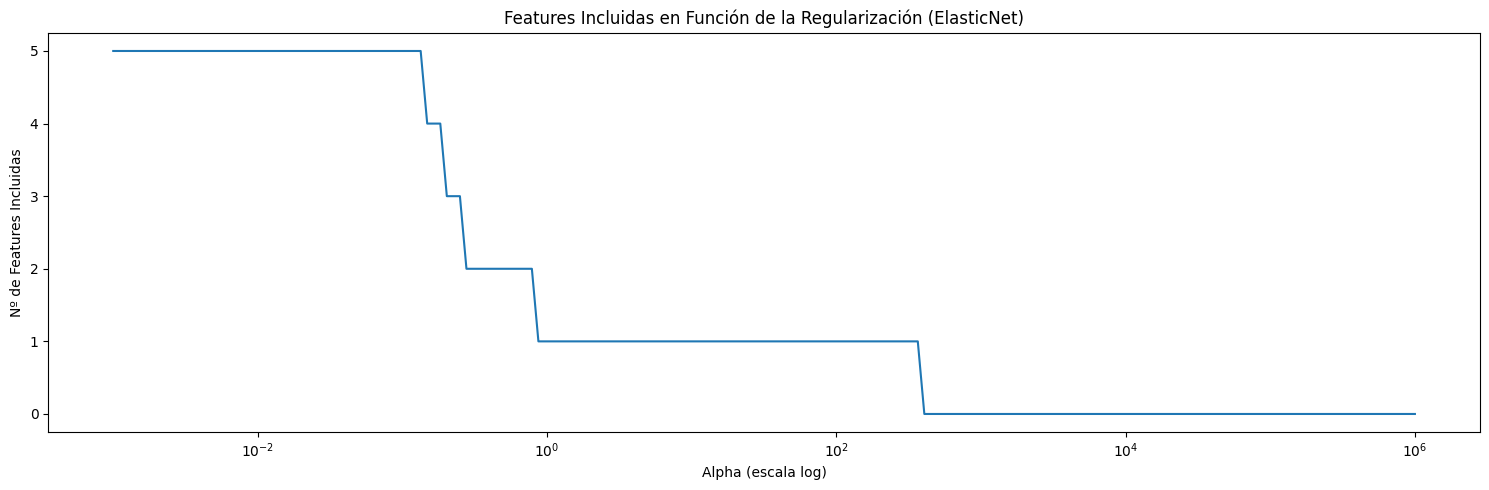

In [172]:
# Número de features incluidas (coeficientes != 0)
n_predictores = []
for alpha in mod.alphas:
    elasticnet = ElasticNet(alpha=alpha, l1_ratio=mod.l1_ratio_, fit_intercept=True, max_iter=10000, tol=1e-3)
    elasticnet.fit(X_train, y_train)
    coef_no_cero = np.sum(elasticnet.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(mod.alphas, n_predictores)
ax.set_xscale('log')
ax.set_xlabel('Alpha (escala log)')
ax.set_ylabel('Nº de Features Incluidas')
ax.set_title('Features Incluidas en Función de la Regularización (ElasticNet)')
plt.tight_layout()
plt.show()

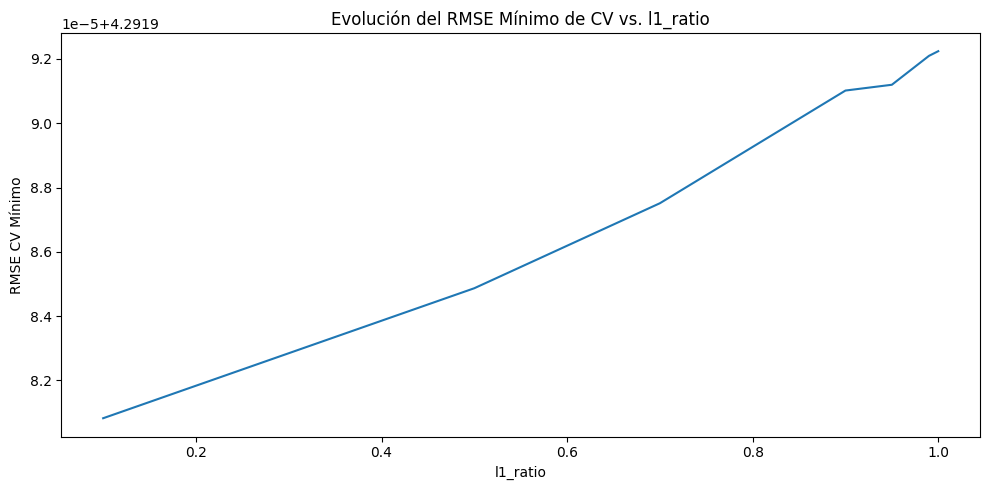

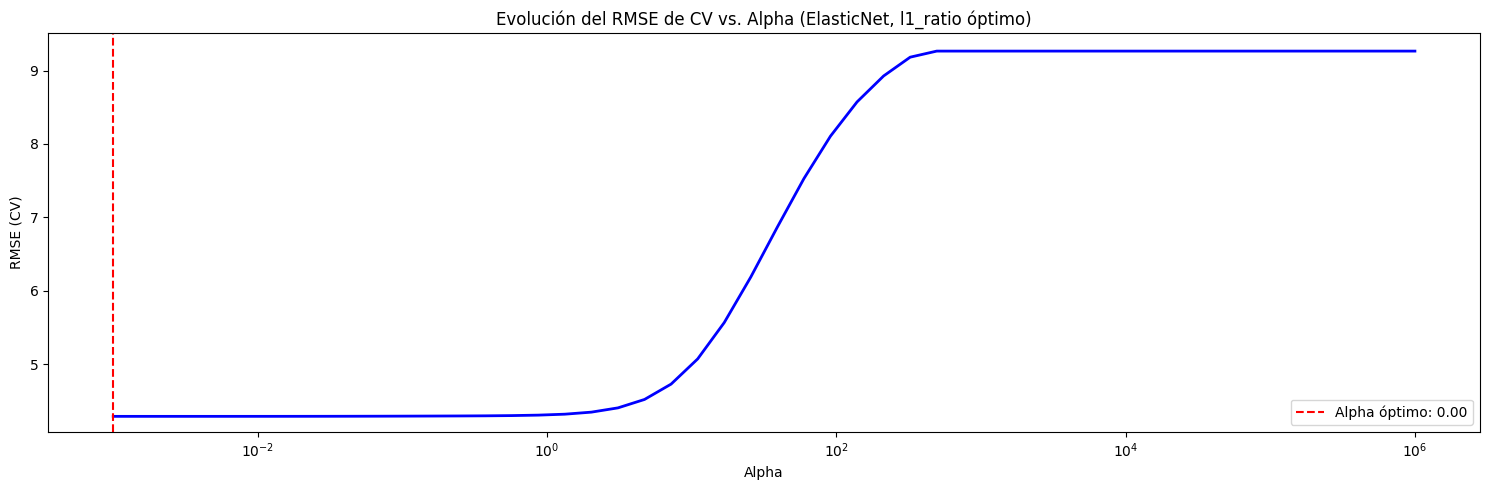

RMSE mínimo en CV: 4.2920 (en alpha=0.0010)

Top 5 combinaciones de l1_ratio y alpha:
     l1_ratio     alpha   rmse_cv
0         0.1  0.001000  4.291981
1         0.1  0.001526  4.291984
50        0.5  0.001000  4.291985
100       0.7  0.001000  4.291988
150       0.9  0.001000  4.291991


In [175]:
# Importaciones necesarias (asegúrate de haber ejecutado el Bloque 1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

# Definir alphas explícitamente
alphas = np.logspace(-3, 6, 50)  # 50 valores para optimizar velocidad

# Evolución del error de validación cruzada por l1_ratio
rmse_cv_by_l1_ratio = {}
for l1_ratio in mod.l1_ratio:
    rmse_cv = []
    for alpha in alphas:
        elasticnet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=10000, tol=1e-2)
        mse_scores = -cross_val_score(elasticnet, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_cv.append(np.sqrt(mse_scores.mean()))
    rmse_cv_by_l1_ratio[l1_ratio] = rmse_cv

# Convertir a DataFrame usando MultiIndex
multi_index = pd.MultiIndex.from_product([mod.l1_ratio, alphas], names=['l1_ratio', 'alpha'])
df_resultados_cv = pd.DataFrame({
    'rmse_cv': np.concatenate([rmse_cv_by_l1_ratio[l1] for l1 in mod.l1_ratio])
}, index=multi_index).reset_index().sort_values('rmse_cv', ascending=True)

# Gráfico de RMSE mínimo por l1_ratio
fig, ax = plt.subplots(figsize=(10, 5))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax=ax)
ax.set_title('Evolución del RMSE Mínimo de CV vs. l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('RMSE CV Mínimo')
plt.tight_layout()
plt.show()

# Gráfico de RMSE vs. alpha para l1_ratio óptimo
rmse_cv = rmse_cv_by_l1_ratio[mod.l1_ratio_]
min_rmse = np.min(rmse_cv)
idx_optimo = np.argmin(rmse_cv)
alpha_optimo = alphas[idx_optimo]

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, rmse_cv, 'b-', linewidth=2)
ax.axvline(alpha_optimo, color='r', linestyle='--', label=f'Alpha óptimo: {alpha_optimo:.2f}')
ax.set_xscale('log')
ax.set_ylim([min_rmse * 0.95, None])
ax.set_title('Evolución del RMSE de CV vs. Alpha (ElasticNet, l1_ratio óptimo)')
ax.set_xlabel('Alpha')
ax.set_ylabel('RMSE (CV)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"RMSE mínimo en CV: {min_rmse:.4f} (en alpha={alpha_optimo:.4f})")
print("\nTop 5 combinaciones de l1_ratio y alpha:")
print(df_resultados_cv.head())

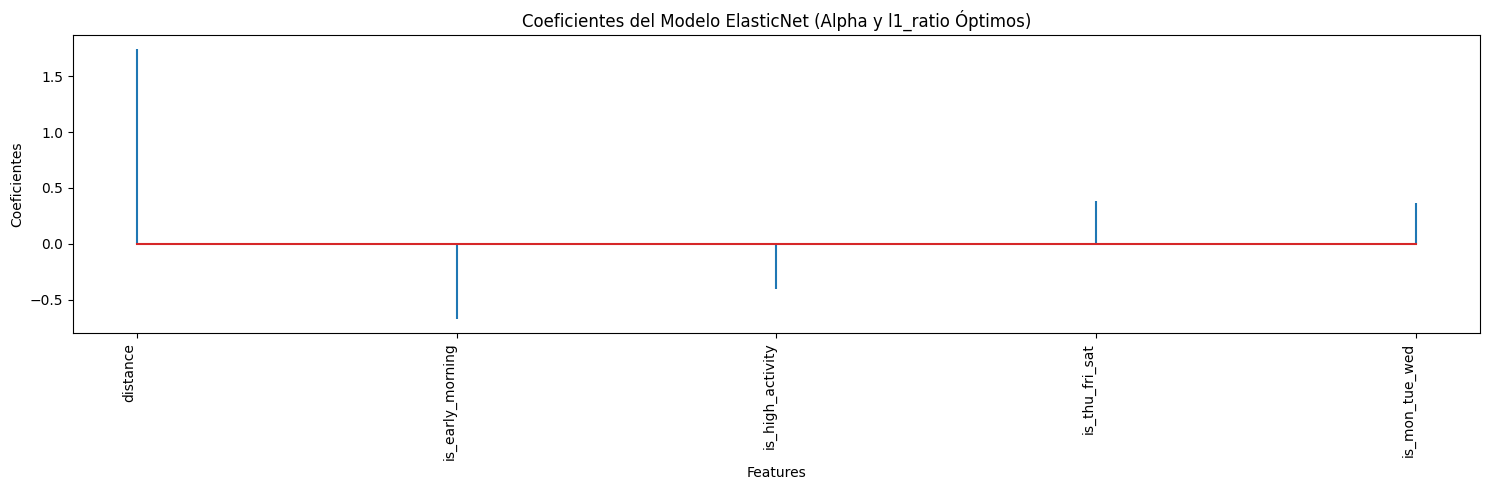

          predictor      coef
0          distance  1.746343
3  is_early_morning -0.678028
4  is_high_activity -0.403057
2    is_thu_fri_sat  0.379146
1    is_mon_tue_wed  0.364739

Features seleccionadas (coef != 0):
          predictor      coef
0          distance  1.746343
3  is_early_morning -0.678028
4  is_high_activity -0.403057
2    is_thu_fri_sat  0.379146
1    is_mon_tue_wed  0.364739


In [176]:
# Coeficientes del modelo final
df_coeficientes = pd.DataFrame({
    'predictor': feature_columns,
    'coef': mod.coef_.flatten()
}).sort_values('coef', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(15, 5))
ax.stem(range(len(df_coeficientes)), df_coeficientes.coef, markerfmt=' ')
ax.set_xticks(range(len(df_coeficientes)))
ax.set_xticklabels(df_coeficientes.predictor, rotation=90, ha='right', size=10)
ax.set_xlabel('Features')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del Modelo ElasticNet (Alpha y l1_ratio Óptimos)')
plt.tight_layout()
plt.show()

print(df_coeficientes)
print("\nFeatures seleccionadas (coef != 0):")
print(df_coeficientes[df_coeficientes.coef != 0])

RMSE en test (ElasticNet): 4.3782
R² en test (ElasticNet): 0.7863


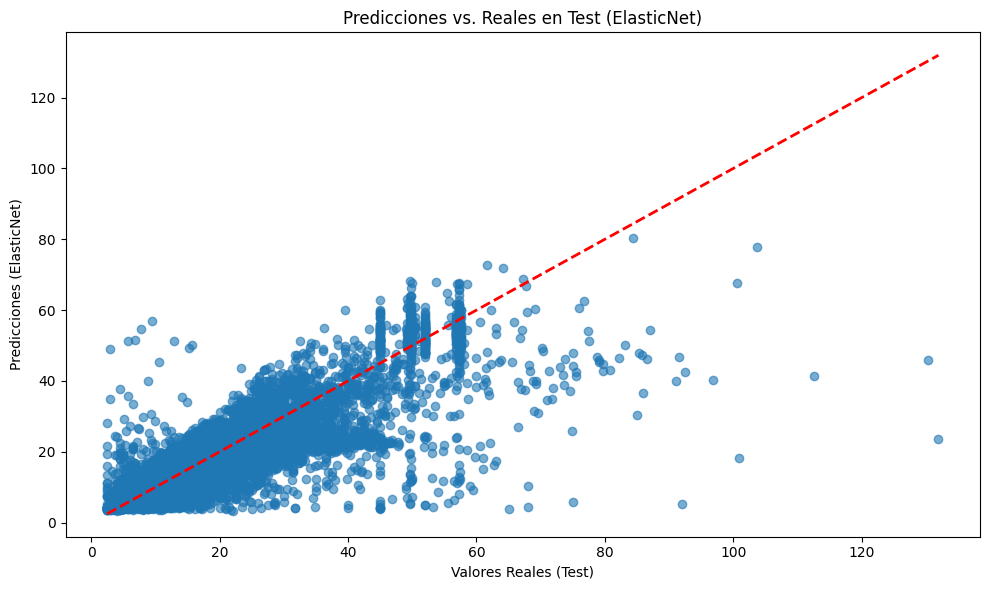

In [177]:
# Predicciones y evaluación en test
y_pred = modelo.predict(X_test)
rmse_elasticnet = np.sqrt(mean_squared_error(y_test, y_pred))
r2_elasticnet = r2_score(y_test, y_pred)

print(f"RMSE en test (ElasticNet): {rmse_elasticnet:.4f}")
print(f"R² en test (ElasticNet): {r2_elasticnet:.4f}")

# Gráfico de predicciones vs reales
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Valores Reales (Test)')
ax.set_ylabel('Predicciones (ElasticNet)')
ax.set_title('Predicciones vs. Reales en Test (ElasticNet)')
plt.tight_layout()
plt.show()

In [178]:
# Generamos valores de rmse_ols para comparación
modelo_ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = modelo_ols.predict(X_test)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

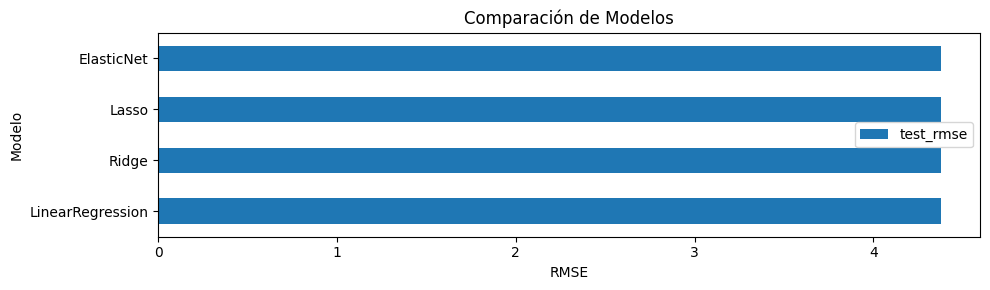

             modelo  test_rmse
0  LinearRegression   4.378167
1             Ridge   4.378200
2             Lasso   4.378200
3        ElasticNet   4.378181


In [179]:
# Comparación de modelos
rmse_ols = rmse_ols if 'rmse_ols' in globals() else None  # Sustituye con tu valor
rmse_ridge = 4.3782  # De tus resultados de Ridge
rmse_lasso = 4.3782  # De tus resultados de Lasso

df_comparacion = pd.DataFrame({
    'modelo': ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'],
    'test_rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elasticnet]
}).dropna()

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('RMSE')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de Modelos')
plt.tight_layout()
plt.show()

print(df_comparacion)